# Analysis of the Cicero corpus & comparison to other authors and works
This notebook was used to develop a talk I gave at the Cicero Digitalis Conference on Feb 25, 2021
video here: https://www.youtube.com/watch?v=tJwmXZHZ924

In [22]:
import os.path
from collections import Counter
from glob import glob
import inspect
import os
import pickle
import sys
from typing import List, Dict, Tuple
from copy import deepcopy
import random

import pandas as pd
import re
from typing import Set

from cltk.sentence.lat import LatinPunktSentenceTokenizer
from cltk.tokenizers.lat.lat import LatinWordTokenizer
from cltk.alphabet.lat import normalize_lat


# from cltk.corpus.latin.phi5_index import PHI5_INDEX
# from cltk.corpus.readers import get_corpus_reader
# from cltk.stem.latin.j_v import JVReplacer
# from cltk.stem.lemma import LemmaReplacer
# from cltk.tokenize.latin.sentence import SentenceTokenizer
# from cltk.tokenize.word import WordTokenizer
import cltk
from random import sample
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('fivethirtyeight')


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
 
from mlyoucanuse.aeoe_replacer import AEOEReplacer
from mlyoucanuse.text_cleaners import ( normalize_accents, disappear_angle_brackets,
                                        drop_punct, disappear_round_brackets, swallow,swallow_obelized_words,
                                        truecase, dehyphenate, accept_editorial,
                                        swallow_braces, swallow_obelized_words,
                                       swallow_angular_brackets,
                                        swallow_square_brackets)

from scipy.optimize import curve_fit
import numpy as np

import cltk
cltk.__version__

cltk 1.0.11 (/Users/todd/opt/anaconda3/envs/mlycu3.8/lib/python3.8/site-packages)

In [31]:
sent_toker = LatinPunktSentenceTokenizer()
word_toker = LatinWordTokenizer()

In [32]:
sent_toker.tokenize("o rem difficilem planeque perditam! quam nihil praetermittis in consilio dando; quam nihil tamen quod tibi ipsi placeat explicas! non esse me una cum Pompeio gaudes")

['o rem difficilem planeque perditam!',
 'quam nihil praetermittis in consilio dando; quam nihil tamen quod tibi ipsi placeat explicas!',
 'non esse me una cum Pompeio gaudes']

In [25]:
cicero_tess = glob(os.path.expanduser('~/cltk_data/latin/text/latin_text_tesserae/texts/cicero.*.tess'))
len(cicero_tess)

122

In [41]:
truecase_file = 'truecase_counter.latin.pkl'

if os.path.exists(truecase_file):
    with open(truecase_file, 'rb') as fin:        
        case_counts = pickle.load(fin)

In [159]:
ANY_ANGLE =  re.compile("<.[^>]+>") # remove tesserae metadata 
sent_lens = []
sent_map={}
sent_idx=0
double_break_idx = []
with open('cicero_tesserae.txt', 'wt') as fout:
    for file in tqdm(cicero_tess, total=len(cicero_tess)):
        with open(file, 'rt') as fin:
            text = fin.read()
            text = swallow(text, ANY_ANGLE)
            text = normalize_lat(text, drop_accents=True, drop_macrons=True, jv_replacement=True, ligature_replacement=True)
            text = accept_editorial(text)
            for sent in sent_toker.tokenize(text):
                tokens = word_toker.tokenize(sent)
                tokens = [truecase(token, case_counts) for token in tokens]
                sent_map[sent_idx] = tokens
                sent_idx +=1
                sent_lens.append(len(tokens))
                fout.write(f"{' '.join(tokens)}\n")
        fout.write(f"\n\n")
        double_break_idx.append(sent_idx)

100%|██████████| 122/122 [00:25<00:00,  4.85it/s]


In [56]:
sent_lens = np.array(sent_lens)
np.mean( sent_lens), np.std( sent_lens), np.max(sent_lens) 

(25.30188163469862, 22.32132597636475, 713)

In [57]:
len([tmp for tmp in sent_lens if tmp > 510])

3

In [58]:
! wc -l cicero_tesserae.txt

   44142 cicero_tesserae.txt


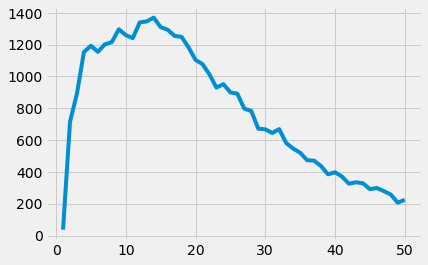

In [59]:
# graph the counts of Cicero sentence lengths
# may be relevant to assessing the model 
cicero_sent_lens= Counter(sent_lens.tolist())
# cicero_sent_lens.most_common(10)
x, y = zip(* sorted(cicero_sent_lens.items(), key=lambda x:x[0]))
plt.plot(x[:50],y[:50])

In [60]:
# Find 200 sentences of 8-18 tokens
# when these are removed from the training set, all the words should still appear in the training set
# but none of the exact sentences should appear in the training set

In [61]:
word_counter = Counter()
for tokens in sent_map.values():
    for tok in tokens:
        word_counter.update({tok:1})

In [129]:
min_tokens, max_tokens, min_token_count = 8, 23, 4 # 8, 19, 4

In [130]:
candidate_sent_idx =[]
for key, vals in sent_map.items():
    istarget = True
    if len(vals) >= min_tokens and len(vals) <= max_tokens:
        for val in vals:
            if word_counter[val] < min_token_count:
                istarget = False
        if istarget:
            candidate_sent_idx.append(key)
len(candidate_sent_idx)

8300

In [131]:
candidate_sent_idx[:3]

[9, 12, 16]

In [132]:
sent_map[12]

['frater',
 'accedit',
 'quem',
 'socium',
 'huius',
 'fortunae',
 'esse',
 'non',
 'erat',
 'aequum',
 '.']

In [133]:
def check_test_candidate( proposed_test_sents_idx:Set[int], sent_map):
    total_tokens = set()    
    for key, vals in sent_map.items():
        if key in proposed_test_sents_idx:
            continue
        for val in vals:            
            total_tokens.add(val)
    return len(total_tokens)

In [134]:
len(word_counter.keys())

70573

In [135]:
test_set_size=2500 # fails around 4k

In [136]:
test_candidates = sample( candidate_sent_idx, test_set_size)
check_test_candidate(set(test_candidates), sent_map)


70573

In [137]:
# create two files cicero.train.txt, cicero.test.txt

In [138]:
# double_break_idx
test_can = set(test_candidates)
double_breaks = set(double_break_idx)

with open('cicero.train.txt', 'wt') as fout:
    for key, vals in sent_map.items():
        if key in test_can:
            fout.write(f"\n\n")
            continue
        fout.write(f"{' '.join(vals)}\n")
        if key in double_breaks:
            fout.write(f"\n\n")

In [139]:
with open('cicero.test.txt', 'wt') as fout:
    for key, vals in sent_map.items():
        if key in test_can:
            fout.write(f"{' '.join(vals)}\n")

In [140]:
test_sentences =[' '.join(sent_map[tmp ]) for tmp in test_candidates]
df = pd.DataFrame({"sentence_idx": test_candidates, "test_sentences": test_sentences })
df.to_csv(f'cicero.test.sentences.{test_set_size}.csv', index=False)
df.head()

,sentence_idx,test_sentences
0,16983,"uidendum est igitur , ut ea liberalitate utamu..."
1,32813,"aut , si omnes homines uelint , obscura esse p..."
2,19411,"ualent pueri , studiose discunt , diligenter d..."
3,25066,"hoc enim identidem dicitis , non intellegere n..."
4,28701,bene hercule narras ; nam istum doctum et sapi...


In [141]:
train_sentences  = [ ' '.join(sent_map[tmp ]) for tmp in sent_map.keys()  if tmp not in test_can ]
train_idx = [ tmp for tmp in sent_map.keys() if tmp not in test_can]
df = pd.DataFrame({"sentence_idx": train_idx, "train_sentences": train_sentences })
df.to_csv(f'cicero.train.sentences.N-{test_set_size}.csv', index=False)
df.head()

,sentence_idx,train_sentences
0,0,etsi cum tu has litteras legeres putabam fore ...
1,1,"sed haec fortasse κενόσπουδα sunt , quae tamen..."
2,2,"quaero autem , quo facilius scire possim quid ..."
3,3,urbem quidem iam refertam esse optimatium audi...
4,4,hinc uero uulgo uadunt ; etiam M'. Lepidus cum...


In [ ]:
# TODO create tesserae.wo.cicero.txt
# create aquinas.txt
# phi5?

In [92]:
def get_word_counts(files:List[str], tesserae=False)-> Dict[str, int] :
    """
    Given a list of files, 
    clean & tokenize the documents
    returns: counter of inflected words 
    """
    inflected_word_counter = Counter()
#     jv_replacer = JVReplacer()
#     aeoe_replacer = AEOEReplacer()
#     toker = WordTokenizer('latin')
#     sent_toker = SentenceTokenizer()
#     lemmatizer = LemmaReplacer('latin')

    for file in files: # , total=len(files), unit='files'):
        with open(file, 'rt') as fin:
            text = fin.read()
            text = text.replace("-\n", "")
            text = text.replace("\n", " ")
            if tesserae:
                text = swallow(text, ANY_ANGLE)
            text = normalize_lat(text, drop_accents=True, drop_macrons=True, jv_replacement=True, ligature_replacement=True)
            text = accept_editorial(text)
            for sent in sent_toker.tokenize(text):
                tokens = word_toker.tokenize(sent)
                tokens = [truecase(token, case_counts) for token in tokens]
                for token in tokens:
                    inflected_word_counter.update({ token: 1})                    

#             for sent in sent_toker.tokenize(text):
#                 sent = dehyphenate(sent) # because it's Phi5
#                 sent = swallow_braces(sent)
#                 sent = swallow_square_brackets(sent)
#                 sent = disappear_round_brackets(sent)
#                 sent = swallow_obelized_words(sent)
#                 sent = disappear_angle_brackets(sent)            
#                 sent = drop_punct(sent)
#                 sent = normalize_accents(sent)            
#                 for word in toker.tokenize(sent):
#                     if word.isnumeric():
#                         continue
#                     inflected_word_counter.update({truecase(word, case_counts) : 1})                    
    return  inflected_word_counter

In [93]:
cicero_inflected_words = get_word_counts(cicero_tess, tesserae=True)

In [142]:
tess_files = glob(os.path.expanduser('~/cltk_data/latin/text/latin_text_tesserae/texts/*.tess'))
tess_wo_cicero = list( set(tess_files) - set(cicero_tess))
len(tess_files), len(tess_wo_cicero)

(762, 640)

In [ ]:
# tesserae without cicero

In [143]:
for file in tqdm(tess_wo_cicero, total=len(tess_wo_cicero)):
    # get filename
    with open(f'cicero.train.tesserae/{os.path.basename(file)}.txt', 'wt') as fout:
        with open(file, 'rt') as fin:
            text = fin.read()
            text = swallow(text, ANY_ANGLE)
            text = normalize_lat(text, drop_accents=True, drop_macrons=True, jv_replacement=True, ligature_replacement=True)
            text = accept_editorial(text)
            for sent in sent_toker.tokenize(text):
                tokens = word_toker.tokenize(sent)
                tokens = [truecase(token, case_counts) for token in tokens]
                fout.write(f"{' '.join(tokens)}\n")
        fout.write(f"\n\n")

100%|██████████| 640/640 [02:16<00:00,  4.69it/s]


In [145]:
# Aquinas 
aquinas = glob("../data/aquinas/*.txt")
len(aquinas)

612

In [146]:
author='aquinas'
for file in tqdm(aquinas, total=len(aquinas)):
    with open(file, 'rt') as fin:
        text = fin.read()
        text = text.replace("-\n", "")
        text = text.replace("\n", " ")        
        text = normalize_lat(text, drop_accents=True, drop_macrons=True, jv_replacement=True, ligature_replacement=True)
        text = accept_editorial(text)
        text = swallow_braces(text)
        filename = os.path.basename (file)
        with open(f"cicero.train.aquinas/{filename}", 'wt') as fout:                
            for sent in sent_toker.tokenize(text):
                tokens = word_toker.tokenize(sent)
                tokens = [truecase(token, case_counts) for token in tokens]
                fout.write(f"{' '.join(tokens)}\n")
            fout.write(f"\n\n")
                
#                 sent = swallow_square_brackets(sent)
#                 sent = disappear_round_brackets(sent)
#                 sent = swallow_obelized_words(sent)
#                 sent = disappear_angle_brackets(sent)            
#                 sentence = [truecase(word, case_counts)
#                             for word in toker.tokenize(sent) 
#                             if not word.isnumeric()]
#                 fout.write(f"{' '.join(sentence)}\n")

100%|██████████| 612/612 [03:46<00:00,  2.70it/s]


In [160]:
test_sentences =[' '.join(sent_map[tmp ]) for tmp in test_candidates]
masked_sentences = []
mask_words = []
mask_idxs = []

for tmp in test_candidates:
    tokens = sent_map[tmp]
    while True:
        can_idx = random.randint(0, len(tokens)-1)
        can_tok = tokens[can_idx]
        if can_tok.isalpha():
            break
    mask_idxs.append(can_idx)
    mask_words.append(can_tok)
    tokens[can_idx] = '[MASK]'
    masked_sentences.append(' '.join(tokens))

df = pd.DataFrame({"sentence_idx": test_candidates, 
                   "test_sentences": test_sentences,
                  "masked_sentences": masked_sentences,
                "masked_words": mask_words,
                "mask_idxs": mask_idxs})
df.to_csv(f'cicero.test.sentences.{test_set_size}.wmask.csv', index=False)
df.head()

,sentence_idx,test_sentences,masked_sentences,masked_words,mask_idxs
0,16983,"uidendum est igitur , ut ea liberalitate utamu...","[MASK] est igitur , ut ea liberalitate utamur ...",uidendum,0
1,32813,"aut , si omnes homines uelint , obscura esse p...","aut , si omnes homines [MASK] , obscura esse p...",uelint,5
2,19411,"ualent pueri , studiose discunt , diligenter d...","ualent pueri , studiose discunt , diligenter d...",nos,10
3,25066,"hoc enim identidem dicitis , non intellegere n...","hoc enim identidem dicitis , non intellegere n...",uoluptatem,10
4,28701,bene hercule narras ; nam istum doctum et sapi...,bene hercule narras ; nam istum [MASK] et sapi...,doctum,6


In [161]:
df.sample(25)

,sentence_idx,test_sentences,masked_sentences,masked_words,mask_idxs
2243,467,id ego uolui Q. sed pluris est .,id ego uolui Q. sed pluris [MASK] .,est,6
1948,29031,est autem quid deceat oratori uidendum non in ...,est autem quid deceat oratori [MASK] non in se...,uidendum,5
279,31037,concedo ; forsitan aliquis aliquando eius modi...,concedo ; forsitan [MASK] aliquando eius modi ...,aliquis,3
1658,15051,"si quid de his rebus dicere uellet , feci pote...","si [MASK] de his rebus dicere uellet , feci po...",quid,1
1480,41136,nunc miser quando tuas iam litteras accipiam ?,[MASK] miser quando tuas iam litteras accipiam ?,nunc,0
535,25667,"non enim omnes eos contemnunt , de quibus male...","non [MASK] omnes eos contemnunt , de quibus ma...",enim,1
163,35671,"itaque eam partem , quae ab exquisita quadam r...","itaque eam partem , quae [MASK] exquisita quad...",ab,5
1186,29347,"quod ab eis uere quadam ex parte , non totum d...","quod ab eis uere [MASK] ex parte , non totum d...",quadam,4
2165,19799,fuit tamen retinendi ordinis causa facienda ia...,fuit tamen [MASK] ordinis causa facienda iactu...,retinendi,2
617,16102,uerum ita est uti dicis ; te deiectum debeo in...,uerum ita est uti dicis ; te deiectum debeo [M...,intellegere,9


In [105]:
# this filtered out too many

for file in tqdm(tess_wo_cicero, total=len(tess_wo_cicero)):
    candidate_counter =  get_word_counts([file], tesserae=True)
    author_words = set(candidate_counter.keys())
    cicero_words = set(cicero_inflected_words.keys())
    common = author_words & cicero_words
    author_uniq = author_words - common 
    P_inflected_unigram_unk = len(author_uniq) / sum(candidate_counter.values()) 
    if P_inflected_unigram_unk <= 0.074:
        # get filename
        with open(f'cicero.train.tesserae/{os.path.basename(file)}.txt', 'wt') as fout:
            with open(file, 'rt') as fin:
                text = fin.read()
                text = swallow(text, ANY_ANGLE)
                text = normalize_lat(text, drop_accents=True, drop_macrons=True, jv_replacement=True, ligature_replacement=True)
                text = accept_editorial(text)
                for sent in sent_toker.tokenize(text):
                    tokens = word_toker.tokenize(sent)
                    tokens = [truecase(token, case_counts) for token in tokens]
                    fout.write(f"{' '.join(tokens)}\n")
            fout.write(f"\n\n")
    else: 
        print(f"too dissimilar {file}")

  0%|          | 1/640 [00:00<01:27,  7.29it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vitruvius.de_architectura.part.7.tess


  0%|          | 3/640 [00:00<01:43,  6.18it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.29.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.amores.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/augustine.epistulae_selections.part.2.11-20.tess


  1%|          | 6/640 [00:01<01:56,  5.44it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/scriptores_historiae_augustae.historia_augusta.part.2.books_6-10.tess


  1%|▏         | 8/640 [00:01<02:25,  4.34it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.1.genesis.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucan.bellum_civile.part.4.tess


  2%|▏         | 10/640 [00:01<01:59,  5.28it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.epigrammata_ausonii_de_diversis_rebus.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/prudentius.hamartigenia.tess


  2%|▏         | 13/640 [00:02<01:04,  9.79it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.epitaphia_heroum_qui_bello_troico_interfuerunt.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.annales.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.59.1_thessalonians.tess


  2%|▏         | 15/640 [00:02<01:12,  8.59it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.7.judges.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.11.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.aeneid.part.8.tess


  3%|▎         | 19/640 [00:02<01:08,  9.05it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.17.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/boethius.de_fide_catholica.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/macrobius.saturnalia.part.2.tess


  3%|▎         | 21/640 [00:02<01:03,  9.71it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/suetonius.de_vita_caesarum.part.8.otho.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/apuleius.metamorphoses.part.11.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucan.bellum_civile.part.2.tess


  4%|▍         | 24/640 [00:03<01:38,  6.28it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.75.2_esdras.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/horace.satires.part.2.tess


  4%|▍         | 26/640 [00:03<01:24,  7.27it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.de_herediolo.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.21.tess


  4%|▍         | 28/640 [00:04<02:31,  4.03it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_elder.naturalis_historia.part.3.books_11-15.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.silvae.part.5.tess


  5%|▍         | 31/640 [00:05<01:48,  5.63it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.26.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.73a.epistle_of_paul_to_the_laodicians.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vitruvius.de_architectura.part.2.tess


  5%|▌         | 33/640 [00:06<02:29,  4.05it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.aeneid.part.10.tess


  5%|▌         | 35/640 [00:07<03:59,  2.53it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.de_bello_gothico.tess


  6%|▌         | 38/640 [00:08<03:08,  3.19it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/curtius_rufus.historiae_alexandri_magni.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/apuleius.metamorphoses.part.9.tess


  6%|▋         | 40/640 [00:08<02:14,  4.46it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/juvencus.historia_evangelica.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/juvencus.historia_evangelica.part.4.tess


  7%|▋         | 42/640 [00:09<03:22,  2.95it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/curtius_rufus.historiae_alexandri_magni.part.4.tess


  7%|▋         | 43/640 [00:09<03:05,  3.23it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/macrobius.saturnalia.part.3.tess


  7%|▋         | 46/640 [00:10<02:11,  4.53it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/bede.historiam_ecclesiasticam_gentis_anglorum.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.technopaegnion.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ennius.annales.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.36.obadiah.tess


  8%|▊         | 48/640 [00:10<01:54,  5.18it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.epistularum.tess


  8%|▊         | 49/640 [00:11<02:50,  3.46it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.21.psalms.tess


  8%|▊         | 51/640 [00:11<02:22,  4.15it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_younger.letters.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/persius.satires.tess


  8%|▊         | 52/640 [00:11<02:40,  3.67it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca_the_elder.controversiae.part.2.tess


  9%|▊         | 55/640 [00:12<02:25,  4.01it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/boethius.consolatio_philosophiae.part.4.tess


  9%|▉         | 56/640 [00:12<02:15,  4.30it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.epidicus.tess


  9%|▉         | 58/640 [00:13<02:03,  4.71it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.asinaria.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.fasti.part.2.tess


  9%|▉         | 60/640 [00:13<01:37,  5.93it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.georgics.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.15.tess


 10%|▉         | 63/640 [00:13<01:04,  8.97it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.annales.part.16.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.de_raptu_proserpinae.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.satisfactio.tess


 10%|█         | 65/640 [00:14<01:26,  6.63it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.14.2_chronicles.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/corippus.johannis.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.libri_de_fastis_conclusio.tess


 11%|█         | 69/640 [00:14<01:01,  9.35it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.de_constantia.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.romulea.part.4.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.25.wisdom.tess


 11%|█         | 71/640 [00:14<01:05,  8.72it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.12.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.11.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.in_consulatum_olybrii_et_probini.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.griphus_ternarii_numeri.tess


 12%|█▏        | 74/640 [00:15<00:58,  9.61it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.de_consolatione_ad_marciam.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.annales.part.6.tess


 12%|█▏        | 76/640 [00:15<00:58,  9.59it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.40.habbakuk.tess


 12%|█▏        | 78/640 [00:16<02:22,  3.93it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_elder.naturalis_historia.part.4.books_16-20.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/manilius.astronomicon.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.61.1_timothy.tess


 12%|█▎        | 80/640 [00:16<01:53,  4.94it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.6.tess


 13%|█▎        | 81/640 [00:16<01:57,  4.74it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.annales.part.4.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.8.tess


 13%|█▎        | 84/640 [00:17<01:46,  5.24it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/aurelius_victor.epitome_de_caesaribus.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_flaccus.argonautica.part.4.tess


 13%|█▎        | 86/640 [00:17<01:27,  6.31it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.in_rufinum.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.9.tess


 14%|█▍        | 88/640 [00:18<01:41,  5.43it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/columella.de_re_rustica.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_younger.letters.part.6.tess


 14%|█▍        | 91/640 [00:18<01:10,  7.84it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.thebaid.part.12.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.55.galatians.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/corippus.johannis.part.7.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/priscian.carmen_in_laudem_Anastasii_imperatoris.part.1.tess


 15%|█▍        | 93/640 [00:18<01:08,  7.98it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.46.2_maccabees.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.romulea.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.56.ephesians.tess


 15%|█▌        | 96/640 [00:18<00:56,  9.56it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/macrobius.saturnalia.part.6.tess


 15%|█▌        | 97/640 [00:19<01:06,  8.18it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.stichus.tess


 15%|█▌        | 99/640 [00:19<01:25,  6.30it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.rudens.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/boethius.consolatio_philosophiae.part.2.tess


 16%|█▌        | 101/640 [00:20<01:40,  5.36it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.annales.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.74.1_esdras.tess


 16%|█▌        | 103/640 [00:20<01:15,  7.10it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.44.malachi.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.3.tess


 16%|█▋        | 105/640 [00:20<01:28,  6.05it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.47.matthew.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.11.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.epithalamium_de_nuptiis_honorii_augusti.tess


 17%|█▋        | 109/640 [00:21<01:06,  7.93it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/augustine.epistulae_selections.part.6.51-62.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.8.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.thebaid.part.4.tess


 18%|█▊        | 112/640 [00:21<01:12,  7.30it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/macrobius.saturnalia.part.7.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.41.zephoniah.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.11.tess


 18%|█▊        | 113/640 [00:21<01:09,  7.56it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/manilius.astronomicon.part.3.tess


 18%|█▊        | 115/640 [00:25<06:28,  1.35it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.22.proverbs.tess


 18%|█▊        | 116/640 [00:25<05:19,  1.64it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.31.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.4.tess


 18%|█▊        | 118/640 [00:25<03:29,  2.49it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.annales.part.13.tess


 19%|█▉        | 122/640 [00:27<03:04,  2.82it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.aeneid.part.12.tess


 19%|█▉        | 124/640 [00:28<03:16,  2.62it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.11.1_kings.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.epicedion_in_patrem.tess


 20%|█▉        | 126/640 [00:28<02:20,  3.67it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.tristia.part.3.tess


 20%|█▉        | 127/640 [00:29<03:51,  2.22it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/juvenal.satires.tess


 20%|██        | 128/640 [00:29<03:39,  2.33it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/priscian.perihegesis.tess


 20%|██        | 129/640 [00:30<03:35,  2.38it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.4.numbers.tess


 20%|██        | 130/640 [00:30<03:05,  2.74it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.annales.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.5.tess


 21%|██        | 133/640 [00:30<01:51,  4.54it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.ex_ponto.part.4.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/rutilius.de_reditu.tess


 21%|██        | 134/640 [00:31<02:17,  3.69it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/bede.historiam_ecclesiasticam_gentis_anglorum.part.4.tess


 21%|██▏       | 137/640 [00:32<02:33,  3.29it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.16.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.fasti.part.4.tess


 22%|██▏       | 139/640 [00:32<01:48,  4.62it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/prudentius.psychomachia.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vitruvius.de_architectura.part.3.tess


 22%|██▏       | 142/640 [00:33<01:27,  5.71it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.ars_amatoria.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vitruvius.de_architectura.part.8.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.35.amos.tess


 23%|██▎       | 145/640 [00:34<02:03,  4.01it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/glass.washingtonii_vita.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.de_vita_beata.tess


 23%|██▎       | 147/640 [00:34<01:44,  4.73it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.in_eutropium.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.annales.part.12.tess


 23%|██▎       | 148/640 [00:34<02:20,  3.50it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.31.ezekiel.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/priscian.carmen_in_laudem_Anastasii_imperatoris.tess


 24%|██▍       | 152/640 [00:35<01:53,  4.29it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.thebaid.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.6.tess


 24%|██▍       | 153/640 [00:35<01:39,  4.92it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.thebaid.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.de_consulatu_stilichonis.part.1.tess


 24%|██▍       | 155/640 [00:36<01:24,  5.75it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.phaedra.tess


 25%|██▍       | 158/640 [00:36<01:16,  6.32it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.2.exodus.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/corippus.johannis.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.pr.tess


 25%|██▍       | 159/640 [00:37<01:33,  5.15it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ennodius.opera.tess


 25%|██▌       | 161/640 [00:37<01:31,  5.26it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.medea.tess


 25%|██▌       | 163/640 [00:37<01:09,  6.91it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_maximus.facta_et_dicta_memorabilia.part.9.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/boethius.consolatio_philosophiae.part.1.tess


 26%|██▌       | 165/640 [00:37<01:06,  7.12it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/columella.de_re_rustica.part.9.tess


 26%|██▌       | 167/640 [00:38<01:18,  6.06it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.16.tess


 26%|██▋       | 169/640 [00:39<01:51,  4.23it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.cistellaria.tess


 27%|██▋       | 172/640 [00:39<01:29,  5.22it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/prudentius.dittochaeon.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.12.tess


 27%|██▋       | 174/640 [00:39<01:18,  5.90it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/augustine.epistulae_selections.part.4.31-40.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/corippus.johannis.part.1.tess


 28%|██▊       | 177/640 [00:40<01:59,  3.86it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/manilius.astronomicon.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/macrobius.saturnalia.part.4.tess


 28%|██▊       | 180/640 [00:41<01:28,  5.21it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.thebaid.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.17.tess


 28%|██▊       | 182/640 [00:41<01:44,  4.39it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca_the_elder.suasoriae.tess


 29%|██▊       | 183/640 [00:42<02:08,  3.56it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintilian.institutio_oratoria.part.1.tess


 29%|██▉       | 186/640 [00:44<04:06,  1.84it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_elder.naturalis_historia.part.5.books_21-25.tess


 29%|██▉       | 187/640 [00:44<03:31,  2.14it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/curtius_rufus.historiae_alexandri_magni.part.8.tess


 29%|██▉       | 188/640 [00:45<03:41,  2.04it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_elder.naturalis_historia.part.1.books_1-5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.66.james.tess


 30%|██▉       | 190/640 [00:45<03:19,  2.26it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/scriptores_historiae_augustae.historia_augusta.part.4.books_16-21.tess


 30%|███       | 192/640 [00:46<02:42,  2.76it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/columella.de_re_rustica.part.1.tess


 30%|███       | 194/640 [00:47<02:17,  3.24it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tibullus.elegies.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.de_brevitate_vitae.tess


 31%|███       | 196/640 [00:47<01:45,  4.21it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.aeneid.part.11.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_younger.letters.part.7.tess


 31%|███       | 199/640 [00:47<01:04,  6.86it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.troades.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.de_consulatu_stilichonis.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.medicamina_faciei_femineae.tess


 32%|███▏      | 202/640 [00:47<00:52,  8.42it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucan.bellum_civile.part.6.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/suetonius.de_vita_caesarum.part.9.vitellius.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.tristia.part.1.tess


 32%|███▏      | 203/640 [00:48<00:55,  7.85it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vitruvius.de_architectura.part.10.tess


 32%|███▏      | 204/640 [00:48<01:11,  6.11it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/paulus_diaconus.carmina.tess


 32%|███▏      | 206/640 [00:48<01:21,  5.36it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_maximus.facta_et_dicta_memorabilia.part.4.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucan.bellum_civile.part.10.tess


 33%|███▎      | 211/640 [00:49<00:52,  8.15it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.70.2_john.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.romulea.part.7.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.14.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.57.philippians.tess


 33%|███▎      | 213/640 [00:50<01:54,  3.72it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_elder.naturalis_historia.part.2.books_6-10.tess


 33%|███▎      | 214/640 [00:50<01:56,  3.65it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.12.1_chronicles.tess


 34%|███▍      | 217/640 [00:51<01:24,  5.00it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.historiae.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/prudentius.epilogus.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.8.tess


 34%|███▍      | 220/640 [00:52<01:36,  4.35it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/apuleius.metamorphoses.part.8.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.12.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.71.3_john.tess


 35%|███▍      | 223/640 [00:52<01:08,  6.04it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_maximus.facta_et_dicta_memorabilia.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.15.tess


 35%|███▌      | 224/640 [00:52<01:31,  4.53it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.poenulus.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/macrobius.fragment.tess


 35%|███▌      | 226/640 [00:53<01:12,  5.74it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/servius_honoratus.in_virgilii_georgicon_libros_commentarius.part.4.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_maximus.facta_et_dicta_memorabilia.part.7.tess


 36%|███▌      | 229/640 [00:53<01:23,  4.94it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.27.isaiah.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/juvencus.historia_evangelica.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.4.tess


 36%|███▋      | 233/640 [00:54<01:30,  4.51it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.68.2_peter.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.aeneid.part.6.tess


 37%|███▋      | 234/640 [00:55<01:31,  4.44it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucretius.de_rerum_natura.part.4.tess


 37%|███▋      | 237/640 [00:55<01:07,  5.94it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.18.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/anonymous.laudes_domini.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.thebaid.part.8.tess


 37%|███▋      | 238/640 [00:55<01:06,  6.06it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_flaccus.argonautica.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.67.1_peter.tess


 38%|███▊      | 242/640 [00:56<01:13,  5.44it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/polignac.imitatio.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucan.bellum_civile.part.7.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.62.2_timothy.tess


 38%|███▊      | 245/640 [00:56<00:48,  8.15it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.30.baruch.tess


 38%|███▊      | 246/640 [00:56<00:54,  7.28it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.28.tess


 39%|███▉      | 248/640 [00:57<01:04,  6.04it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/celsus.de_medicina.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.fasti.part.6.tess


 39%|███▉      | 249/640 [00:57<01:09,  5.62it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucretius.de_rerum_natura.part.3.tess


 39%|███▉      | 250/640 [01:22<43:27,  6.69s/it]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/suetonius.de_vita_caesarum.part.11.titus.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.24.song_of_songs.tess


 40%|███▉      | 254/640 [01:22<16:46,  2.61s/it]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/marcus_mincuius_felix.octavius.tess


 40%|████      | 256/640 [01:25<12:24,  1.94s/it]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.aeneid.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.54.2_corinthians.tess


 40%|████      | 258/640 [01:25<08:02,  1.26s/it]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.romulea.part.3.tess


 41%|████      | 260/640 [01:26<05:44,  1.10it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.7.tess


 41%|████      | 262/640 [01:26<04:05,  1.54it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.13.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.38.micah.tess


 42%|████▏     | 268/640 [01:28<01:57,  3.17it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/manilius.astronomicon.part.4.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca_the_elder.fragmenta.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucan.bellum_civile.part.1.tess


 42%|████▏     | 269/640 [01:28<01:41,  3.67it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.10.tess


 42%|████▏     | 270/640 [01:28<01:42,  3.61it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.historiae.part.3.tess


 42%|████▏     | 271/640 [01:29<01:45,  3.49it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/servius_honoratus.in_virgilii_georgicon_libros_commentarius.part.2.tess


 43%|████▎     | 274/640 [01:30<01:45,  3.46it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/apuleius.metamorphoses.part.6.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.19.tess


 43%|████▎     | 275/640 [01:30<01:28,  4.13it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.thebaid.part.11.tess


 43%|████▎     | 278/640 [01:30<01:02,  5.76it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/curtius_rufus.historiae_alexandri_magni.part.6.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/apuleius.metamorphoses.part.5.tess


 44%|████▍     | 281/640 [01:31<00:57,  6.25it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/celsus.de_medicina.part.7.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.gratiarum_actio.tess


 44%|████▍     | 282/640 [01:31<00:52,  6.81it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/suetonius.de_vita_caesarum.part.12.domitian.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.romulea.part.5.tess


 45%|████▍     | 285/640 [01:31<00:47,  7.54it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/apuleius.florida.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/suetonius.de_vita_caesarum.part.6.nero.tess


 45%|████▍     | 286/640 [01:31<00:47,  7.41it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.thebaid.part.6.tess


 45%|████▌     | 288/640 [01:32<01:17,  4.53it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.pseudolus.tess


 45%|████▌     | 289/640 [01:32<01:18,  4.48it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/suetonius.de_vita_caesarum.part.3.tiberius.tess


 46%|████▌     | 295/640 [01:35<02:04,  2.77it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucretius.de_rerum_natura.part.6.tess


 46%|████▋     | 297/640 [01:36<01:39,  3.45it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.silvae.part.1.tess


 47%|████▋     | 299/640 [01:36<01:45,  3.23it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.10.2_samuel.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.14.tess


 47%|████▋     | 303/640 [01:37<01:15,  4.44it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.33.hosea.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.panegyricus_de_quarto_consulatu_honorii_augusti.tess


 48%|████▊     | 307/640 [01:38<00:47,  6.96it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.18.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.19.esther.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/boethius.consolatio_philosophiae.part.5.tess


 48%|████▊     | 308/640 [01:38<00:52,  6.30it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/augustine.epistulae_selections.part.1.1-10.tess


 48%|████▊     | 310/640 [01:38<01:01,  5.33it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.annales.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.13.tess


 49%|████▉     | 312/640 [01:39<01:00,  5.44it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_younger.letters.part.9.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.4.tess


 49%|████▉     | 315/640 [01:39<01:08,  4.78it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.21a.old_latin_psalms.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.de_xii_caesaribus.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.15.tess


 50%|████▉     | 317/640 [01:40<01:01,  5.23it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucretius.de_rerum_natura.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.tristia.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.6.tess


 50%|████▉     | 319/640 [01:40<00:46,  6.89it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.14.tess


 50%|█████     | 320/640 [01:40<01:02,  5.10it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/columella.de_re_rustica.part.6.tess


 51%|█████     | 324/640 [01:41<00:57,  5.48it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.de_consolatione_ad_helviam.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.ars_amatoria.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.29.lamentations.tess


 51%|█████▏    | 328/640 [01:41<00:41,  7.59it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.17.tobias.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.58.colossians.tess


 51%|█████▏    | 329/640 [01:42<01:15,  4.11it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_elder.naturalis_historia.part.6.books_26-30.tess


 52%|█████▏    | 330/640 [01:42<01:18,  3.97it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/bede.historiam_ecclesiasticam_gentis_anglorum.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.mosella.tess


 52%|█████▏    | 332/640 [01:43<01:14,  4.11it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/bede.historiam_ecclesiasticam_gentis_anglorum.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/suetonius.de_vita_caesarum.part.10.vespasian.tess


 52%|█████▏    | 334/640 [01:43<00:58,  5.21it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/suetonius.de_vita_caesarum.part.5.claudius.tess


 52%|█████▏    | 335/640 [01:43<00:59,  5.13it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.aulularia.tess


 53%|█████▎    | 337/640 [01:56<12:07,  2.40s/it]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.curculio.tess


 53%|█████▎    | 340/640 [01:57<05:26,  1.09s/it]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/horace.epistles.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_maximus.facta_et_dicta_memorabilia.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.10.tess


 53%|█████▎    | 341/640 [01:57<04:26,  1.12it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/catullus.carmina.tess


 54%|█████▍    | 344/640 [02:07<11:07,  2.25s/it]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.amores.part.3.tess


 54%|█████▍    | 347/640 [02:08<04:46,  1.02it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.22.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.tristia.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.10.tess


 55%|█████▍    | 349/640 [02:08<03:01,  1.60it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.53.1_corinthians.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/curtius_rufus.historiae_alexandri_magni.part.9.tess


 55%|█████▍    | 351/640 [02:08<01:54,  2.53it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.aeneid.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.fasti.part.5.tess


 55%|█████▌    | 352/640 [02:09<01:43,  2.77it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.3.leviticus.tess


 55%|█████▌    | 353/640 [02:09<01:48,  2.65it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.heroides.part.1.1-15.tess


 56%|█████▌    | 356/640 [02:10<01:22,  3.46it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/columella.de_re_rustica.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.phoenissae.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/horace.odes.part.2.tess


 56%|█████▌    | 359/640 [02:11<01:15,  3.70it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca_the_elder.controversiae.part.10.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.panegyricus_dictus_manlio_theodoro_consuli.tess


 56%|█████▋    | 361/640 [02:11<01:00,  4.63it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.6.joshua.tess


 57%|█████▋    | 364/640 [02:12<00:54,  5.06it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.25.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.24.tess


 57%|█████▋    | 366/640 [02:12<00:47,  5.74it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.9.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.30.tess


 57%|█████▋    | 367/640 [02:12<00:45,  5.96it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.agamemnon.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.georgics.part.1.tess


 58%|█████▊    | 370/640 [02:13<00:59,  4.50it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/juvencus.historia_evangelica.part.3.tess


 58%|█████▊    | 373/640 [02:26<08:12,  1.84s/it]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.persa.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.thebaid.part.7.tess


 59%|█████▊    | 375/640 [02:26<04:26,  1.00s/it]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_younger.letters.part.8.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.oedipus.tess


 59%|█████▉    | 379/640 [02:27<01:46,  2.46it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.20.job.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.60.2_thessalonians.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.13.tess


 60%|█████▉    | 381/640 [02:27<01:14,  3.47it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucan.bellum_civile.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.19.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.panegyricus_de_tertio_consulatu_honorii_augusti.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.34.joel.tess


 61%|██████    | 388/640 [02:28<00:34,  7.35it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.cento_nuptialis.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.cupido_cruciatus.tess


 61%|██████    | 390/640 [02:28<00:33,  7.43it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.de_laudibus_dei.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/prudentius.contra_symmachum.part.1.tess


 62%|██████▏   | 394/640 [02:30<01:06,  3.71it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tertullian.apologeticum.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucan.bellum_civile.part.8.tess


 62%|██████▏   | 395/640 [02:30<01:01,  3.98it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.17.tess


 62%|██████▏   | 399/640 [02:31<00:47,  5.11it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.agricola.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.de_bissula.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.8.tess


 63%|██████▎   | 402/640 [02:31<00:41,  5.70it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.43.zechariah.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_flaccus.argonautica.part.5.tess


 63%|██████▎   | 403/640 [02:32<00:39,  5.99it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.15.tess


 63%|██████▎   | 405/640 [02:32<00:38,  6.11it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.annales.part.15.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.aeneid.part.4.tess


 64%|██████▎   | 407/640 [02:33<00:51,  4.49it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.tristia.part.4.tess


 64%|██████▍   | 410/640 [02:33<00:46,  4.97it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.ad_lucilium_epistulae_morales.part.6.51-60.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.18.judith.tess


 65%|██████▍   | 414/640 [02:34<00:51,  4.41it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/florus.epitome_bellorum_omnium_annorum.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.de_raptu_proserpinae.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.23.ecclesiastes.tess


 65%|██████▌   | 416/640 [02:35<00:43,  5.09it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/prudentius.apotheosis.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.fasti.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/aristotle.economics_book_3.tess


 66%|██████▌   | 420/640 [02:35<00:32,  6.75it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.16.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.3.tess


 66%|██████▌   | 422/640 [02:35<00:30,  7.17it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.9.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_flaccus.argonautica.part.2.tess


 66%|██████▋   | 425/640 [02:36<00:23,  9.01it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/augustine.epistulae_selections.part.3.21-30.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.in_rufinum.part.1.tess


 67%|██████▋   | 427/640 [02:36<00:23,  9.02it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.georgics.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.9.tess


 67%|██████▋   | 430/640 [02:37<00:40,  5.22it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tertullian.de_spectaculis.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_maximus.facta_et_dicta_memorabilia.part.3.tess


 67%|██████▋   | 431/640 [02:37<00:38,  5.45it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/corippus.johannis.part.6.tess


 68%|██████▊   | 432/640 [02:37<00:47,  4.42it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/apuleius.apologia.tess


 68%|██████▊   | 433/640 [02:38<00:51,  4.02it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/servius_honoratus.in_virgilii_georgicon_libros_commentarius.part.3.tess


 68%|██████▊   | 434/640 [02:38<01:00,  3.42it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/scriptores_historiae_augustae.historia_augusta.part.1.books_1-5.tess


 68%|██████▊   | 436/640 [02:39<01:04,  3.16it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_maximus.facta_et_dicta_memorabilia.part.1.tess


 68%|██████▊   | 437/640 [02:40<01:31,  2.23it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/petronius.satyricon.tess


 69%|██████▊   | 439/640 [02:40<01:02,  3.22it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.14.tess


 69%|██████▉   | 441/640 [02:41<01:38,  2.01it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/propertius.elegies.tess


 69%|██████▉   | 443/640 [02:42<01:10,  2.78it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.bacchides.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.eclogues.tess


 70%|██████▉   | 445/640 [02:42<01:06,  2.92it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/macrobius.saturnalia.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.6.tess


 70%|██████▉   | 446/640 [02:43<01:00,  3.20it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/scriptores_historiae_augustae.historia_augusta.part.3.books_11-15.tess


 70%|███████   | 450/640 [02:44<00:45,  4.15it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/apuleius.metamorphoses.part.7.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.1.tess


 70%|███████   | 451/640 [02:44<00:39,  4.75it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.de_laudibus_dei.part.3.tess


 71%|███████   | 453/640 [02:45<00:50,  3.69it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/bede.historiam_ecclesiasticam_gentis_anglorum.part.1.tess


 71%|███████▏  | 457/640 [02:45<00:34,  5.31it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.aeneid.part.7.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.13.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vitruvius.de_architectura.part.5.tess


 72%|███████▏  | 460/640 [02:46<00:23,  7.69it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.romulea.part.10.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.precationes.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.10.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.romulea.part.fragments.tess


 72%|███████▎  | 464/640 [02:46<00:17,  9.87it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.thebaid.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/corippus.johannis.part.4.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.9.tess


 73%|███████▎  | 466/640 [02:52<03:00,  1.03s/it]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/polignac.antilucretius.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucretius.de_rerum_natura.part.2.tess


 73%|███████▎  | 470/640 [02:53<01:40,  1.68it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_elder.naturalis_historia.part.7.books_31-37.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.ephemeris_id_est_totius_diei_negotium.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.romulea.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.commemoratio_professorum_burdigalensium.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.octavia.tess


 74%|███████▍  | 473/640 [02:53<01:05,  2.55it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/curtius_rufus.historiae_alexandri_magni.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/apuleius.metamorphoses.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/horace.epodes.tess


 75%|███████▍  | 478/640 [02:54<00:41,  3.90it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.13.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vitruvius.de_architectura.part.1.tess


 75%|███████▌  | 481/640 [02:55<00:34,  4.58it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.ad_lucilium_epistulae_morales.part.9.81-90.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/horace.ars_poetica.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_flaccus.argonautica.part.8.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.39.nahum.tess


 76%|███████▌  | 484/640 [02:55<00:27,  5.58it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.truculentus.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.ex_ponto.part.1.tess


 76%|███████▋  | 488/640 [02:56<00:16,  9.06it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/suetonius.de_vita_caesarum.part.2.augustus.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.oratio_consulis_ausonii_versibus_rhopalicis.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.6.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/horace.odes.part.4.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.carmina_minora.tess


 77%|███████▋  | 491/640 [02:57<00:29,  5.03it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.de_ira.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/sallust.histories.tess


 77%|███████▋  | 492/640 [02:57<00:27,  5.43it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_maximus.facta_et_dicta_memorabilia.part.6.tess


 77%|███████▋  | 495/640 [02:57<00:23,  6.13it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.heroides.part.2.16-21.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.72.jude.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.de_tranquillitate_animi.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.ordo_urbium_nobilium.tess


 78%|███████▊  | 499/640 [02:58<00:22,  6.29it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_maximus.facta_et_dicta_memorabilia.part.8.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.12.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.2.tess


 78%|███████▊  | 501/640 [02:58<00:18,  7.34it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.7.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.7.tess


 79%|███████▊  | 503/640 [02:59<00:19,  6.99it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/curtius_rufus.historiae_alexandri_magni.part.7.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.3.tess


 79%|███████▉  | 507/640 [03:00<00:34,  3.87it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/polignac.epia.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/apuleius.metamorphoses.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.de_raptu_proserpinae.part.2.tess


 80%|███████▉  | 509/640 [03:00<00:26,  4.97it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.de_origine_et_situ_germanorum_liber.tess


 80%|███████▉  | 511/640 [03:01<00:26,  4.89it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.captivi.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/columella.de_re_rustica.part.7.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/horace.carmen_saeculare.tess


 80%|████████  | 513/640 [03:01<00:21,  5.93it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.annales.part.14.tess


 80%|████████  | 515/640 [03:01<00:20,  6.17it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.14.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_flaccus.argonautica.part.7.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.21b.psalm.tess


 81%|████████  | 518/640 [03:02<00:16,  7.62it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/boethius.consolatio_philosophiae.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.panegyricus_de_sexto_consulatu_honorii_augusti.tess


 81%|████████▏ | 520/640 [03:02<00:17,  6.82it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/apuleius.metamorphoses.part.4.tess


 82%|████████▏ | 522/640 [03:02<00:16,  7.17it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.27.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.ibis.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.historiae.part.5.tess


 82%|████████▏ | 524/640 [03:03<00:17,  6.67it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/columella.de_re_rustica.part.3.tess


 82%|████████▏ | 525/640 [03:03<00:22,  5.15it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.49.luke.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.8.tess


 82%|████████▎ | 528/640 [03:03<00:17,  6.33it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.23.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.romulea.part.8.tess


 83%|████████▎ | 530/640 [03:04<00:18,  5.98it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.hercules_furens.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/celsus.de_medicina.part.8.tess


 83%|████████▎ | 532/640 [03:04<00:15,  6.82it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/suetonius.de_vita_caesarum.part.1.julius.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.silvae.part.4.tess


 83%|████████▎ | 534/640 [03:04<00:13,  7.66it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.52.romans.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.de_providentia.tess


 84%|████████▍ | 536/640 [03:04<00:13,  7.92it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.silvae.part.3.tess


 84%|████████▍ | 538/640 [03:05<00:14,  6.81it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_younger.letters.part.1.tess


 84%|████████▍ | 540/640 [03:05<00:13,  7.39it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/martial.epigrams.part.12.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.aeneid.part.1.tess


 85%|████████▍ | 542/640 [03:05<00:14,  6.59it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/horace.odes.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.4.tess


 85%|████████▍ | 543/640 [03:05<00:14,  6.80it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.apocolocyntosis.tess


 85%|████████▌ | 547/640 [03:07<00:18,  4.98it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.annales.part.11.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.de_consulatu_stilichonis.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.silvae.part.2.tess


 86%|████████▌ | 548/640 [03:07<00:27,  3.38it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.ludus_septem_sapientum.tess


 86%|████████▋ | 552/640 [03:08<00:15,  5.51it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.historiae.part.4.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.63.titus.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.ars_amatoria.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.romulea.part.6.tess


 87%|████████▋ | 555/640 [03:08<00:10,  7.85it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/tacitus.historiae.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/apuleius.metamorphoses.part.1.tess


 87%|████████▋ | 559/640 [03:09<00:12,  6.57it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_younger.letters.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.praefatiunculae.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.7.tess


 88%|████████▊ | 561/640 [03:09<00:14,  5.34it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/macrobius.saturnalia.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.thebaid.part.9.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.76.prayer_of_manasseh.tess


 88%|████████▊ | 563/640 [03:09<00:10,  7.04it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.7.tess


 88%|████████▊ | 566/640 [03:11<00:18,  3.93it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.4.tess


 89%|████████▉ | 568/640 [03:11<00:14,  4.81it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/horace.satires.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/suetonius.de_vita_caesarum.part.7.galba.tess


 89%|████████▉ | 570/640 [03:11<00:10,  6.96it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.8.ruth.tess


 90%|████████▉ | 573/640 [03:12<00:10,  6.20it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.26.sirach.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.ex_ponto.part.2.tess


 90%|████████▉ | 575/640 [03:12<00:10,  5.98it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/italicus.ilias_latina.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.10.tess


 90%|█████████ | 577/640 [03:12<00:11,  5.27it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/suetonius.de_vita_caesarum.part.4.caligula.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.in_eutropium.part.1.tess


 91%|█████████ | 580/640 [03:13<00:10,  5.73it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/manilius.astronomicon.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.65.hebrews.tess


 91%|█████████ | 582/640 [03:13<00:09,  5.83it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/plautus.casina.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vitruvius.de_architectura.part.9.tess


 91%|█████████▏| 585/640 [03:14<00:08,  6.26it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/celsus.de_medicina.part.4.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vitruvius.de_architectura.part.6.tess


 92%|█████████▏| 587/640 [03:14<00:07,  6.96it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/gellius.attic_nights.part.20.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/corippus.johannis.part.8.tess


 92%|█████████▏| 589/640 [03:14<00:06,  7.90it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.15.ezra.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/silius_italicus.punica.part.1.tess


 92%|█████████▏| 591/640 [03:14<00:06,  8.05it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.aeneid.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vitruvius.de_architectura.part.4.tess


 93%|█████████▎| 593/640 [03:15<00:06,  7.48it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/pliny_the_younger.letters.part.5.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.remedia_amoris.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.georgics.part.4.tess


 93%|█████████▎| 596/640 [03:15<00:06,  6.56it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/augustine.epistulae_selections.part.5.41-50.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/celsus.de_medicina.part.5.tess


 94%|█████████▎| 599/640 [03:16<00:05,  7.30it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.5.deuteronomy.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.42.haggaiah.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/claudian.de_bello_gildonico.tess


 94%|█████████▍| 602/640 [03:16<00:07,  5.34it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/quintus_smyrnaeus.fall_of_troy.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.orestes.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.versus_paschales_pro_augusto_dicti.tess


 94%|█████████▍| 604/640 [03:17<00:05,  6.95it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.de_laudibus_dei.part.1.tess


 95%|█████████▍| 606/640 [03:17<00:05,  5.96it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/columella.de_re_rustica.part.4.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/curtius_rufus.historiae_alexandri_magni.part.10.tess


 95%|█████████▌| 608/640 [03:17<00:05,  5.81it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.achilleid.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.thyestes.tess


 95%|█████████▌| 610/640 [03:18<00:04,  6.13it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.fasti.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/statius.thebaid.part.10.tess


 95%|█████████▌| 611/640 [03:18<00:05,  4.90it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.51.acts.tess


 96%|█████████▌| 612/640 [03:18<00:05,  4.76it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/seneca.hercules_oetaeus.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/dracontius.romulea.part.9.tess


 96%|█████████▋| 616/640 [03:20<00:06,  3.64it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/servius_honoratus.in_virgilii_georgicon_libros_commentarius.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/celsus.de_medicina.part.6.tess


 97%|█████████▋| 618/640 [03:20<00:04,  4.88it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.14.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.metamorphoses.part.5.tess


 97%|█████████▋| 620/640 [03:20<00:03,  5.65it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucan.bellum_civile.part.9.tess


 97%|█████████▋| 622/640 [03:20<00:03,  5.71it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/aurelius_victor.de_caesaribus.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/horace.odes.part.1.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/corippus.johannis.part.3.tess


 98%|█████████▊| 626/640 [03:21<00:03,  4.65it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.48.mark.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.amores.part.2.tess


 98%|█████████▊| 629/640 [03:22<00:01,  6.41it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ovid.ex_ponto.part.3.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.32.daniel.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_flaccus.argonautica.part.6.tess


 99%|█████████▉| 632/640 [03:22<00:01,  6.14it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.parentalia.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/jerome.vulgate.part.16.nehemiah.tess


 99%|█████████▉| 633/640 [03:23<00:01,  5.87it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/prudentius.contra_symmachum.part.2.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ausonius.eclogarum_liber.tess


 99%|█████████▉| 636/640 [03:23<00:00,  6.88it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/ammianus.rerum_gestarum.part.20.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/valerius_flaccus.argonautica.part.3.tess


100%|█████████▉| 638/640 [03:23<00:00,  6.44it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/columella.de_re_rustica.part.8.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/apuleius.metamorphoses.part.10.tess


100%|██████████| 640/640 [03:24<00:00,  3.14it/s]

too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/vergil.aeneid.part.9.tess
too dissimilar /Users/todd/cltk_data/latin/text/latin_text_tesserae/texts/lucan.bellum_civile.part.3.tess


In [106]:
! ls cicero.train.tesserae/*.txt | wc -l 

      95


In [ ]:
# Obelized:
# quae si non essent sedulitate effectae et †benivolentie va† , liceret mihi abire in solitudines aliquas .
# nunc ne id quidem licet .
# 
# Odd section
# Ut cum uidemus speciem primum candorem -que caeli , dein conuersionis celeritatem tantam quantam cogitare non possumus , tum uicissitudines dierum ac noctium commutationes -que temporum quadrupertitas ad maturitatem frugum et ad temperationem corporum aptas eorum -que omnium moderatorem et ducem solem , lunam -que adcretio -ne et deminutio -ne luminis quasi fastorum notantem et significantem dies , tum in eodem orbe in duodecim partes distributo quinque stellas ferri eosdem cursus constantissime seruantis disparibus inter se motibus , nocturnam -que caeli formam undique sideribus ornatam , tum globum terrae eminentem e mari , fixum in medio mundi uniuersi loco , duabus oris distantibus habitabilem et cultum , quarum altera , quam nos incolimus , Sub a/xe posita ad ste/llas septem , unde ho/rrifer , Aquilo/nis stridor ge/lidas molitu/r niues , altera australis , ignota nobis , quam uocant Graeci ἀντίχθονα , ceteras partis incultas , quod aut frigore rigeant aut urantur calore ; hic autem , ubi habitamus , non intermittit suo tempore Caelu/m nitescere , a/rbores fronde/scere , Uite/s laetificae pa/mpinis pube/scere , Rami/ bacarum ube/rtate incurue/scere , Segete/s largiri fru/ges , florere o/mnia , Fonte/s scatere , herbis pra/ta conuesti/rier , tum multitudinem pecudum partim ad uescendum , partim ad cultus agrorum , partim ad uehendum , partim ad corpora uestienda , hominem -que ipsum quasi contemplatorem caeli ac deorum cultorem atque ho- minis utili

## Text Cleaning
from http://udallasclassics.org/wp-content/uploads/maurer_files/APPARATUSABBREVIATIONS.pdf

[...] Square brackets, or in recent editions wavy brackets ʺ{...}ʺ, enclose words etc. that an editor thinks should be deleted (see ʺdel.ʺ) or marked as out of place (see ʺsecl.ʺ).

[...] Square  brackets  in  a  papyrus  text, or in an  inscription,  enclose  places  where words have been lost through physical damage.  If this happens in mid-line, editors  use  ʺ[...]ʺ.    If  only  the  end  of  the  line  is  missing,  they  use  a  single  bracket ʺ[...ʺ      If  the  lineʹs  beginning  is  missing,  they  use  ʺ...]ʺ    Within  the  brackets, often each dot represents one missing letter.

[[...]] Double brackets enclose letters or words deleted by the medieval copyist himself.

(...) Round  brackets  are  used  to  supplement  words  abbreviated  by  the  original  copyist; e.g. in an inscription: ʺtrib(unus) mil(itum) leg(ionis) IIIʺ

<...> diamond  (  =  elbow  =  angular)  brackets  enclose  words  etc.  that  an  editor  has  added (see ʺsuppl.ʺ)

†   An obelus (pl. obeli) means that the word(s etc.) is very plainly corrupt, but the editor  cannot  see  how  to  emend.    If  only  one  word  is  corrupt,  there  is  only  one obelus, which precedes the word; if two or more words are corrupt, two obeli  enclose  them.    (Such  at  least  is  the  rule--but  that  rule  is  often  broken,  especially  in  older  editions,  which  sometimes  dagger  several  words  using  only one obelus.)  To dagger words in this way is to ʺobelizeʺ them.

## Load/Build Truecasing dictionary; count all cased tokens, use to normalize cases later

In [4]:
truecase_file = 'truecase_counter.latin.pkl'

if os.path.exists(truecase_file):
    with open(truecase_file, 'rb') as fin:        
        case_counts = pickle.load(fin)
else:
    tesserae = get_corpus_reader(corpus_name='latin_text_tesserae', language='latin')
    case_counts = Counter()
    jv_replacer = JVReplacer()
    aeoe_replacer = AEOEReplacer()
    toker = WordTokenizer('latin')
    sent_toker = SentenceTokenizer()
    lemmatizer = LemmaReplacer('latin')
    
    for file in tqdm(tesserae.fileids(), total=len(tesserae.fileids())):
        for sent in tesserae.sents(file):
            sent = aeoe_replacer.replace(jv_replacer.replace(drop_punct(sent)))
            sent = normalize_accents(sent)
            sent = accept_editorial(sent)
            for token in toker.tokenize(sent):
                case_counts.update({token:1})
                
    with open(truecase_file, 'wb') as fout:        
        pickle.dump(case_counts, fout) 

len(case_counts)

309529

In [5]:
print(sample(list(case_counts.items()), 25))

[('Epicharmium', 1), ('litabilis', 1), ('Adliciunt', 1), ('Praediximus', 1), ('caliculus', 1), ('uolitare', 50), ('Militiam', 3), ('adfuerim', 5), ('Pica', 2), ('induperatorem', 2), ('pericla', 22), ('menstrua', 45), ('delenisse', 1), ('subtrahit', 22), ('uastaris', 1), ('epiphonema', 2), ('tempnunt', 1), ('gloriantis', 2), ('fuluas', 6), ('uthinam', 1), ('Pici', 3), ('Durati', 1), ('uersicolori', 11), ('armeniacum', 1), ('dubitauimus', 1)]


In [6]:
def get_word_counts(files:List[str])->Tuple[Dict[str, int], Dict[str, int]]:
    """
    Given a list of files, 
    clean & tokenize the documents
    returns: Tuple(counter of lemmatized words, counter of inflected words)
    """
    lemma_word_counter = Counter()
    inflected_word_counter = Counter()
    jv_replacer = JVReplacer()
    aeoe_replacer = AEOEReplacer()
    toker = WordTokenizer('latin')
    sent_toker = SentenceTokenizer()
    lemmatizer = LemmaReplacer('latin')

    for file in files: # , total=len(files), unit='files'):
        with open(file, 'rt') as fin:
            text = fin.read()
            text = text.replace("-\n", "")
            text = text.replace("\n", " ")
            text = aeoe_replacer.replace(jv_replacer.replace( text))
            for sent in sent_toker.tokenize(text):
                sent = dehyphenate(sent) # because it's Phi5
                sent = swallow_braces(sent)
                sent = swallow_square_brackets(sent)
                sent = disappear_round_brackets(sent)
                sent = swallow_obelized_words(sent)
                sent = disappear_angle_brackets(sent)            
                sent = drop_punct(sent)
                sent = normalize_accents(sent)            
                # lemmatizer prefers lower 
    #             sent = lemmatizer.lemmatize(sent.lower(), return_string=True)
                for word in toker.tokenize(sent):
                    if word.isnumeric():
                        continue
                    inflected_word_counter.update({truecase(word, case_counts) : 1})                    
                    word = lemmatizer.lemmatize(word.lower(), return_string=True)
                    # normalize capitals
                    lemma_word_counter.update({truecase(word, case_counts) : 1})
    return  inflected_word_counter, lemma_word_counter

In [7]:
def word_stats(author:str,
               inflected_counter:Counter,
                lemma_counter:Counter)->Tuple[float, float]:
    """
    Compute statistics for an author's corpus
    """
    nw = sum(lemma_counter.values())
    print(f"Total count of all word tokens in {author} corpus: {nw:,}")
    print(f"Total number of distinct, inflected words/tokens in {author} corpus: {len(inflected_counter):,}")
    print(f"Total number of lemmatized words/tokens in {author} corpus {len(lemma_counter):,}")
    # Count of inflected unigrams occuring only once
    ciw1 = sum([1 for key, val in inflected_counter.items() if val == 1]) 
    print(f"Count of inflected tokens only occuring once {ciw1:,}")
    # Count of lemmatized unigrams occuring only once
    cw1 = sum([1 for key, val in lemma_counter.items() if val == 1])
    print(f"Count of lemmatized tokens only occuring once {cw1:,}")
    Piu_one = round(ciw1 / nw,3)
    print(f"Probability of a single count unigram occuring in the {author} corpus: {Piu_one:.3f}") 
    Plu_one = round(cw1 / nw, 3)
    print(f"Probability of a single count lemmatized unigram in a novel form occuring in the {author} corpus: {Plu_one:.3f}") 
    return (Piu_one, Plu_one)

In [8]:
# Cicero works
cicero_files = glob(f"{os.path.expanduser('~')}/cltk_data/latin/text/phi5/individual_works/LAT0474.TXT-0*.txt")
len (cicero_files)              

75

In [9]:
cicero_lemmas_counter_file = 'cicero_lemmas_counter.pkl'
cicero_inflected_counter_file = 'cicero_inflected_counter.pkl'

if os.path.exists(cicero_lemmas_counter_file) and os.path.exists(cicero_inflected_counter_file):
    with open(cicero_lemmas_counter_file, 'rb') as fin:
        cicero_lemmas = pickle.load(fin)
    with open(cicero_inflected_counter_file, 'rb') as fin:
        cicero_inflected_words = pickle.load(fin)
else:
    cicero_inflected_words, cicero_lemmas  = get_word_counts(cicero_files)

if not os.path.exists(cicero_lemmas_counter_file):
    with open(cicero_lemmas_counter_file, 'wb') as fout:
        pickle.dump(cicero_lemmas, fout)
if not os.path.exists(cicero_inflected_counter_file):
    with open(cicero_inflected_counter_file, 'wb') as fout:
        pickle.dump(cicero_inflected_words, fout)

In [11]:
word_stats(author='Cicero',           
            inflected_counter=cicero_inflected_words,
            lemma_counter=cicero_lemmas)

Total count of all word tokens in Cicero corpus: 1,196,512
Total number of distinct, inflected words/tokens in Cicero corpus: 75,705
Total number of lemmatized words/tokens in Cicero corpus 23,345
Count of inflected tokens only occuring once 34,608
Count of lemmatized tokens only occuring once 10,656
Probability of a single count unigram occuring in the Cicero corpus: 0.029
Probability of a single count lemmatized unigram in a novel form occuring in the Cicero corpus: 0.009


(0.029, 0.009)

In [12]:
word_counts =  sorted(cicero_inflected_words.items(), key=lambda x:x[1], reverse=True)
# words, counts = zip(*word_counts)


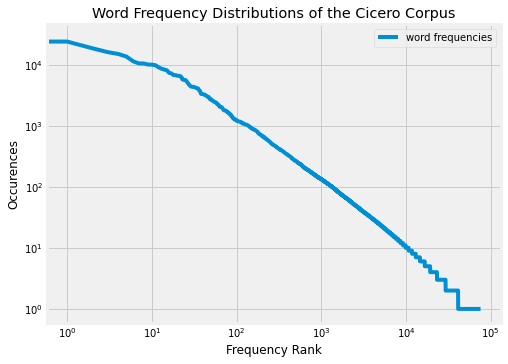

In [13]:
top_label, side_label, bottom_label = ('Frequency Rank',
                                       'Occurences',
                                       'Word Frequency Distributions of the Cicero Corpus')
fig = plt.figure(figsize=(7,5))
plt.xlabel(top_label)
plt.ylabel(side_label)
plt.title(bottom_label)
ax = fig.gca()
plt.yscale('log')
indices, values = zip(*word_counts)
# plt.bar(range(len(values)), values)
plt.loglog(range(len(values)), values, label='word frequencies')
# plt.axvline(x=np.mean(all_vals), color='k', linestyle='-', label='mean')
# plt.axvline(x=np.mean(all_vals) + np.std(all_vals), color='b', linestyle='-', label='std')
# plt.axvline(x=np.mean(all_vals) + (2 * np.std(all_vals)), color='m', linestyle='-', label='std2')
plt.legend(loc='upper right')
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
# plt.show()
plt.savefig('cicero_frequency_distributions.png')

In [14]:
word_counts[:5]

[('et', 27952), ('in', 23862), ('non', 18471), ('est', 16045), ('ut', 14957)]

In [15]:
word_counts[-5:]

[('adaequatus', 1),
 ('obfuerint', 1),
 ('ignorauit', 1),
 ('erudiri', 1),
 ('adprobarunt', 1)]

In [16]:
first_last = word_counts[:5] +word_counts[-5:]

No handles with labels found to put in legend.


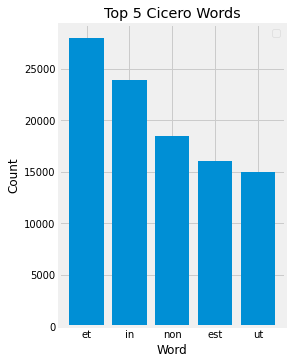

In [17]:
top_label, side_label, bottom_label = ('Word',
                                       'Count',
                                       'Top 5 Cicero Words')
fig = plt.figure(figsize=(4,5))
plt.xlabel(top_label)
plt.ylabel(side_label)
plt.title(bottom_label)
ax = fig.gca()
# plt.yscale('log')
# word_counts[:5] +word_counts[-5:]
indices, values = zip(*word_counts[:5])
plt.bar(indices , values)
# plt.loglog(range(len(values)), values, label='word frequencies')
# plt.axvline(x=np.mean(all_vals), color='k', linestyle='-', label='mean')
# plt.axvline(x=np.mean(all_vals) + np.std(all_vals), color='b', linestyle='-', label='std')
# plt.axvline(x=np.mean(all_vals) + (2 * np.std(all_vals)), color='m', linestyle='-', label='std2')
plt.legend(loc='upper right')
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
# plt.show()
plt.savefig('cicero_top5_words.png')

In [18]:
num_f1 = sum([1 for tmp, cnt in cicero_inflected_words.items() if cnt == 1])
num_f2 = sum([1 for tmp, cnt in cicero_inflected_words.items() if cnt == 2])
num_f3 = sum([1 for tmp, cnt in cicero_inflected_words.items() if cnt == 3])
num_f4 = sum([1 for tmp, cnt in cicero_inflected_words.items() if cnt == 4])
num_f5 = sum([1 for tmp, cnt in cicero_inflected_words.items() if cnt == 5])
values=[num_f5, num_f4, num_f3, num_f2, num_f1 ]

In [19]:
values

[2622, 3936, 6095, 11858, 34608]

In [20]:
p0 = round(34608 / sum(cicero_inflected_words.values()),3)
p0

0.029

In [21]:
sum(cicero_inflected_words.values())

1196512

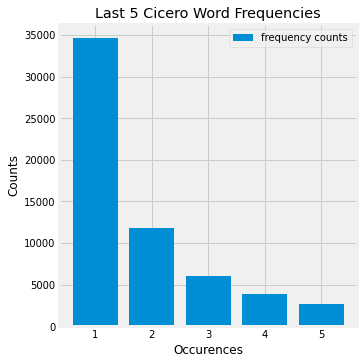

In [23]:
top_label, side_label, bottom_label = ('Occurences',
                                       'Counts',
                                       'Last 5 Cicero Word Frequencies')
fig = plt.figure(figsize=(5,5))
plt.xlabel(top_label)
plt.ylabel(side_label)
plt.title(bottom_label)
ax = fig.gca()
plt.yscale('linear')
# indices, values = zip(*word_counts[-5:])
values = [num_f1, num_f2, num_f3, num_f4, num_f5]
plt.bar(range(1,len(values)+1), values, label='frequency counts')
# plt.loglog(range(len(values)), values, label='word frequencies')
# plt.axvline(x=np.mean(all_vals), color='k', linestyle='-', label='mean')
# plt.axvline(x=np.mean(all_vals) + np.std(all_vals), color='b', linestyle='-', label='std')
# plt.axvline(x=np.mean(all_vals) + (2 * np.std(all_vals)), color='m', linestyle='-', label='std2')
plt.legend(loc='upper right')
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
# plt.show()
plt.savefig('cicero_last_five_word_frequencies.png')

# Calculate lemmatized values

In [25]:
# Probability of a single count unigram occuring in the Cicero corpus: 0.029
# Probability of a single count lemmatized unigram in a novel form occuring in the Cicero corpus: 0.009
# (0.029, 0.009)
# With Curve fitting
# Probability of encountering a new inflected word in new Cicero 0.054 (according to curve fitting)
# Probability of encountering a new lemmatized word form in new Cicero 0.017 (according to curve fitting)
# (0.054, 0.017)

Expected unknown count 32,361
Probability of encountering a new lemmatized word form in new Cicero 0.027 (according to curve fitting)
[(10, 249), (9, 280), (8, 332), (7, 406), (6, 542), (5, 644), (4, 959), (3, 1508), (2, 3108), (1, 10656)]


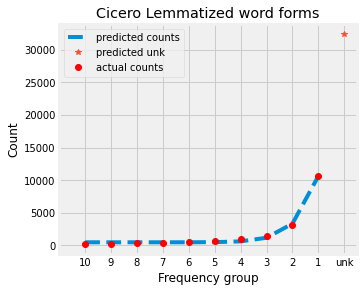

In [26]:
freq_vals = []
num_samples =10
for i in range(num_samples,0,-1):
    freq_vals.append( (i, sum([1 for tmp, cnt in cicero_lemmas.items() if cnt == i])))

X,y = zip(*freq_vals)
# We will reverse the scale to predict the next number according to a Power Law distribution
X =list(reversed(X))

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c
  
popt, pcov = curve_fit(func_powerlaw, X, y, maxfev=2000)
expected_unk_count  = round(func_powerlaw(num_samples + 1 , *popt)) 
plt.figure(figsize=(5,4))
plt.plot(X, func_powerlaw(X, *popt), '--', label='predicted counts')
plt.plot(X[-1] + 1, func_powerlaw(X[-1]+1, *popt), '*', label='predicted unk')
plt.plot(X, y, 'ro', label='actual counts')
plt.title("Cicero Lemmatized word forms")
plt.xlabel("Frequency group" )
plt.ylabel("Count")
locs, labels = plt.xticks()  
plt.xticks(range(12), ['']+ [str(tmp) for tmp in range(10,0,-1)] +['unk']) 
plt.legend()
# plt.show()
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
plt.savefig('cicero_lemmatized_words_unk_prob_curve_fit.png')

expected_unk_count  = round(func_powerlaw(num_samples + 1, *popt) ) 
P_new_lemma_word = expected_unk_count / sum(cicero_lemmas.values())
print(f"Expected unknown count {expected_unk_count:,}")
print(f"Probability of encountering a new lemmatized word form in new Cicero {round(P_new_lemma_word,3)} (according to curve fitting)")
print(freq_vals)

Expected unknown count 88,198
Probability of encountering a new word in new Cicero 0.074 (according to curve fitting)
[(10, 837), (9, 1018), (8, 1260), (7, 1572), (6, 2018), (5, 2622), (4, 3936), (3, 6095), (2, 11858), (1, 34608)]


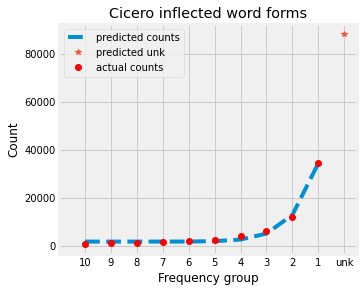

In [27]:
freq_vals = []
num_samples = 10
for i in range(num_samples,0,-1):
    freq_vals.append( (i, sum([1 for tmp, cnt in cicero_inflected_words.items() if cnt == i])))

X,y = zip(*freq_vals)
# We will reverse the scale to predict the next number according to a Power Law distribution
X =list(reversed(X))

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c
 
popt, pcov = curve_fit(func_powerlaw, X, y, maxfev=2000)
expected_unk_count  = round(func_powerlaw(num_samples + 1 , *popt)) 
plt.figure(figsize=(5,4))
plt.plot(X, func_powerlaw(X, *popt), '--', label='predicted counts')
plt.plot(X[-1] + 1, func_powerlaw(X[-1]+1, *popt), '*', label='predicted unk')
plt.plot(X, y, 'ro', label='actual counts')
plt.title("Cicero inflected word forms")
plt.xlabel("Frequency group" )
plt.ylabel("Count")
locs, labels = plt.xticks()  
plt.xticks(range(12), ['']+ [str(tmp) for tmp in range(10,0,-1)] +['unk']) 
plt.legend()
# plt.show()
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
plt.savefig('cicero_inflected_words_unk_prob_curve_fit.png')

expected_unk_count  = round(func_powerlaw(num_samples + 1 , *popt)) 
P_new_word = expected_unk_count / sum(cicero_inflected_words.values())
print(f"Expected unknown count {expected_unk_count:,}")
print(f"Probability of encountering a new word in new Cicero {round(P_new_word,3)} (according to curve fitting)")
print(freq_vals)

In [28]:
# Probability of a single count unigram occuring in the Cicero corpus: 0.029
# Probability of a single count lemmatized unigram in a novel form occuring in the Cicero corpus: 0.009
# (0.029, 0.009)
# With Curve fitting
# Probability of encountering a new inflected word in new Cicero 0.054 (according to curve fitting)
# Probability of encountering a new lemmatized word form in new Cicero 0.017 (according to curve fitting)
# (0.054, 0.017)
# With Power Law Curve fitting
# (0.074, 0.027)
# Probability of encountering a new inflected word in a new page of Cicero: 0.074
# Probability of encountering a new form of lemma in Cicero's use: 0.027

#  So, if you found a new page of Cicero with a 100 words
# we would expect 7 of the words to be new/hitherto/unseen in the Cicero corpus
# we would expect 3 of the words to be words that Cicero had used before, but now in novel forms of the lemmas 

### Good-Turing Frequency Estimation
\begin{align}
p_{0}={\frac {N_{1}}{N}}
\end{align}
The probability of an unseen element is equivalent to the the probability of elements seen only once.

In [29]:
88198/  1196512

0.07371259126527774

In [34]:
author_index = {val:key for key,val in PHI5_INDEX.items()  
                if val != 'Marcus Tullius Cicero, Cicero, Tully'}

def get_phi5_author_files(author_name, author_index):
    stub = author_index[author_name]
    return glob(os.path.expanduser(f'~/cltk_data/latin/text/phi5/individual_works/{stub}*.txt'))

## Visualization of our corpus comparison: 
If you took one page from one author and placed it into Cicero, how surprising would it be?

If the other author's vocabulary was substantially different, it would be noticeable. We can quantify this.

As a result, since we want to predict as close as possible to the author, we should only train a language model where the underlying corpus vocabularies are within a reasonable window of surprise.

In [36]:
jv_replacer = JVReplacer()
aeoe_replacer = AEOEReplacer()
toker = WordTokenizer('latin')
sent_toker = SentenceTokenizer()
lemmatizer = LemmaReplacer('latin')

# Examine Phi5 corpus

In [40]:
results = []
# The following code assumes this is in memory:
# cicero_lemmas, cicero_inflected_words = get_word_counts(cicero_files)    

for author in author_index:
    files = get_phi5_author_files(author, author_index)
    # Get a counter of all the author's distinct words & counter of words collapsed by lemmas
    author_inflected_words, author_lemmas  = get_word_counts(files)        
    # Calculate the overlap & find the differences; lemmas:
    author_words = set(author_lemmas.keys())
    cicero_words = set(cicero_lemmas.keys())
    common = author_words & cicero_words
    author_uniq = author_words - common 
    P_lemma_unigram_unk = len(author_uniq) / sum(author_lemmas.values())
    # now inflected forms: 
    author_words = set(author_inflected_words.keys())
    cicero_words = set(cicero_inflected_words.keys())
    common = author_words & cicero_words
    author_uniq = author_words - common 
    P_inflected_unigram_unk = len(author_uniq) / sum(author_inflected_words.values())
    results.append((author, round(P_inflected_unigram_unk, 3), round(P_lemma_unigram_unk, 3)))
    if P_inflected_unigram_unk <= 0.074:
        for file in files: # , total=len(files), unit='files'):
            with open(file, 'rt') as fin:
                text = fin.read()
                text = text.replace("-\n", "")
                text = text.replace("\n", " ")
                text = aeoe_replacer.replace(jv_replacer.replace( text))
                filename = file[file.rfind('/')+1:]
                with open(f"cicero_training_corpus/{filename}", 'wt') as fout:
                    for sent in sent_toker.tokenize(text):
                        sent = dehyphenate(sent) # because it's Phi5
                        sent = swallow_braces(sent)
                        sent = swallow_square_brackets(sent)
                        sent = disappear_round_brackets(sent)
                        sent = swallow_obelized_words(sent)
                        sent = disappear_angle_brackets(sent)            
#                         sent = drop_punct(sent)
                        sent = normalize_accents(sent)
                        sentence = [truecase(word, case_counts)
                                    for word in toker.tokenize(sent) 
                                    if not word.isnumeric()]
                        fout.write(f"{' '.join(sentence)}\n")


In [25]:
results_map = {key: (val, val2) for key,val,val2 in results}

results = sorted(results, key=lambda x:x[2])

for tmp in results:
    print(tmp)

('Publius Cominius', 0.0, 0.0)
('Publius Cornelius Dolabella', 0.0, 0.0)
('Gaius Calpurnius Piso', 0.0, 0.0)
('Publius Saturius', 0.0, 0.0)
('Lucius Cassius Longinus', 0.0, 0.0)
('Gaius Memmius', 0.0, 0.0)
('Passienus Crispus', 0.0, 0.0)
('Marcus Antonius', 0.0, 0.0)
('Caecilius Metellus', 0.0, 0.0)
('Gaius Aurelius Cotta', 0.0, 0.0)
('Gaius Scribonius Curio avus', 0.0, 0.0)
('Vibius Crispus', 0.0, 0.0)
('Gallus Antipater', 0.0, 0.0)
('Lucius Herennius Balbus', 0.0, 0.0)
('Marcus Antonius triumvir', 0.0, 0.0)
('Sevius Nicanor', 0.0, 0.0)
('Gaius Papirius Carbo Arvina', 0.0, 0.0)
('Gaius vel Lucius Caepasius', 0.0, 0.0)
('Titus Labienus', 0.0, 0.0)
('Lucius Quinctius', 0.0, 0.0)
('Q. Lutatius Catulus iunior', 0.0, 0.0)
('Gaius Servilius Glaucia', 0.0, 0.0)
('Gaius Aquilius Gallus', 0.0, 0.0)
('Lucius Marcius Philippus', 0.0, 0.0)
('Iulius Africanus', 0.0, 0.0)
('Marcus Porcius Cato Uticensis', 0.0, 0.0)
('Publius Clodius Pulcher', 0.0, 0.0)
('Vagellius', 0.0, 0.0)
('Publius Mucius Scaev

In [29]:
author_results = []
for author in author_index:
    files = get_phi5_author_files(author, author_index)
    if len(files) >= 3:
#     print(author, results_map[author])
        author_results.append((author, results_map[author]) )

author_results.sort(key=lambda x: x[1][1])    
for tmp in author_results:
    print(tmp)
    
# the values analogous to Cicero are: (0.02892407263780054, 0.008905886443261747)    
# ~ 0.03  and  0.01 # we can tolerate some distance above this baseline, 2x, 3x, depends
# Results are mapped into Cicero's Vocabulary space
# Table below:
# Author
# Probability of encountering a word once that we've seen in the author previously in a different lemmatized form
# Probability of seeing a truly new word once in this authors corpus 

('Quintus Asconius Pedianus', (0.01, 0.03))
('Gaius, iur., Gaius', (0.011, 0.035))
('Titus Livius, Livy', (0.011, 0.039))
('Marcus Fabius Quintilianus', (0.009, 0.042))
('Gaius Iulius Caesar, Caesar', (0.016, 0.046))
('Lucius Annaeus Seneca senior', (0.016, 0.052))
('Lucius Annaeus Seneca iunior', (0.013, 0.054))
('Aulus Cornelius Celsus', (0.017, 0.056))
('Publius Terentius Afer, Terence', (0.029, 0.059))
('Gaius Sallustius Crispus', (0.021, 0.059))
('Maurus Servius Honoratus, Servius', (0.025, 0.059))
('Titus Maccius Plautus', (0.027, 0.062))
('Publius Ovidius Naso', (0.024, 0.065))
('C. Plinius Caecilius Secundus, Pliny', (0.017, 0.066))
('Titus Lucretius Carus', (0.022, 0.068))
('Scriptores Historiae Augustae', (0.032, 0.071))
('Cornelius Tacitus', (0.025, 0.076))
('Gaius Caesius Bassus', (0.04, 0.08))
('Hyginus Gromaticus', (0.029, 0.083))
('Marcus Valerius Probus', (0.038, 0.084))
('Marcus Cornelius Fronto', (0.036, 0.084))
('Gaius Asinius Pollio', (0.036, 0.09))
('Annius Florus'

#### Translating the statistics:
* Cicero: # ~ 0.03  and  0.01  
* Gaius Iulius Caesar, Caesar (0.016170899832329378, 0.0464137117307334)

#### If one were to find a new page (100 words) of Cicero, one would expect to find: 
* 3 words that Cicero had previously used, but in novel inflected forms 
    * (root words that we know have been used by Cicero, but without previous examples of that particular inflection)
* 1 word hapax legomena to the author
    * Not a global hapax legomena, but one that we have no record of occuring in Cicero before (in any inflected form).
#### if one were to take a page from Caesar and claim it was a new page of Cicero, one would expect to find:
* 2 words that Cicero had previously used but now in a novel inflected form.
* 5 words that Cicero had never used (in any inflected form).


In [18]:
# Let's look at Cicero's near contemporaries, and see if the individual works come closer to 
# matching Cicero's language in terms of Probability Distributions
candidates = ['Gaius Iulius Caesar, Caesar', 
'C. Iul. Caes. Augustus Octavianus',  
'Publius Vergilius Maro, Virgil, Vergil',  
'Gaius Suetonius Tranquillus', 
'Marcus Terentius Varro, Varro', 
'Cornelius Tacitus', 
'Titus Livius, Livy', 
'Lucius Annaeus Seneca senior', 
'Quintus Horatius Flaccus, Horace',  
'Gaius Sallustius Crispus', 
'Titus Lucretius Carus', 
'Lucius Annaeus Seneca iunior']

In [25]:
results = []

for author in candidates:
    files = get_phi5_author_files(author, author_index)
    #     cicero_lemmas, cicero_inflected_words = get_word_counts(cicero_files)    
    for file in files:
        author_inflected_words, author_lemmas = get_word_counts([file])    
        author_words = set(author_lemmas.keys())
        cicero_words = set(cicero_lemmas.keys())
        common = author_words & cicero_words
        author_uniq  = author_words - common 
        P_one_x_lemma_unigram = round(len(author_uniq) / sum(author_lemmas.values()),3)
        author_words = set(author_inflected_words.keys())
        cicero_words = set(cicero_inflected_words.keys())
        common = author_words & cicero_words
        author_uniq  = author_words - common 
        P_one_x_inflected_unigram = round(len(author_uniq) / sum(author_inflected_words.values()), 3)
        results.append((author, file, sum(author_inflected_words.values()), P_one_x_inflected_unigram, P_one_x_lemma_unigram))

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

In [30]:
for author, _, count, P_one_x_inflected_unigram, P_one_x_lemma_unigram in results:
    if P_one_x_lemma_unigram != 0.0:
        print (author, count, P_one_x_inflected_unigram, P_one_x_lemma_unigram)
# Cicero's values for:
# Probability of unigrams that occur once, Probability of a lemmatized unigram occurring once
# (0.02892407263780054, 0.008905886443261747)  Cicero's values for

Gaius Iulius Caesar, Caesar 286 0.0034965034965034965 0.006993006993006993
Gaius Iulius Caesar, Caesar 134 0.08955223880597014 0.13432835820895522
Gaius Iulius Caesar, Caesar 386 0.0025906735751295338 0.0025906735751295338
Gaius Iulius Caesar, Caesar 49 0.061224489795918366 0.20408163265306123
Gaius Iulius Caesar, Caesar 33437 0.014923587642432037 0.0506923468014475
Gaius Iulius Caesar, Caesar 179 0.027932960893854747 0.061452513966480445
Gaius Iulius Caesar, Caesar 46014 0.018603033859260223 0.05059329769200678
C. Iul. Caes. Augustus Octavianus 2398 0.26980817347789826 0.2964970809007506
C. Iul. Caes. Augustus Octavianus 85 0.07058823529411765 0.12941176470588237
C. Iul. Caes. Augustus Octavianus 1424 0.07935393258426966 0.12289325842696629
C. Iul. Caes. Augustus Octavianus 33 0.030303030303030304 0.12121212121212122
C. Iul. Caes. Augustus Octavianus 69 0.11594202898550725 0.21739130434782608
C. Iul. Caes. Augustus Octavianus 338 0.08875739644970414 0.1301775147928994
C. Iul. Caes. Au

In [41]:
aquinas = glob("../data/aquinas/*.txt")
len(aquinas)

612

In [43]:
results = []
author='aquinas'
for file in tqdm(aquinas):
    author_inflected_words, author_lemmas = get_word_counts([file])    
    author_words = set(author_lemmas.keys())
    cicero_words = set(cicero_lemmas.keys())
    common = author_words & cicero_words
    author_uniq  = author_words - common 
    P_one_x_lemma_unigram = len(author_uniq) / sum(author_lemmas.values())
    author_words = set(author_inflected_words.keys())
    cicero_words = set(cicero_inflected_words.keys())
    common = author_words & cicero_words
    author_uniq  = author_words - common 
    P_one_x_inflected_unigram = len(author_uniq) / sum(author_inflected_words.values())
    results.append((author, file, sum(author_inflected_words.values()), P_one_x_inflected_unigram, P_one_x_lemma_unigram))
    if P_one_x_inflected_unigram <= 0.074:
        with open(file, 'rt') as fin:
            text = fin.read()
            text = text.replace("-\n", "")
            text = text.replace("\n", " ")
            text = aeoe_replacer.replace(jv_replacer.replace(text))
            filename = file[file.rfind('/')+1:]
            with open(f"cicero_training_corpus_aquinas/{filename}", 'wt') as fout:
                for sent in sent_toker.tokenize(text):
                    sent = dehyphenate(sent) # because it's Phi5
                    sent = swallow_braces(sent)
                    sent = swallow_square_brackets(sent)
                    sent = disappear_round_brackets(sent)
                    sent = swallow_obelized_words(sent)
                    sent = disappear_angle_brackets(sent)            
    #                         sent = drop_punct(sent)
                    sent = normalize_accents(sent)
                    sentence = [truecase(word, case_counts)
                                for word in toker.tokenize(sent) 
                                if not word.isnumeric()]
                    fout.write(f"{' '.join(sentence)}\n")

100%|██████████| 612/612 [14:49<00:00,  1.45s/it]


In [15]:
results[:3]

[('aquinas',
  '../data/aquinas/ccm0.txt',
  1134,
  0.03262786596119929,
  0.06437389770723104),
 ('aquinas',
  '../data/aquinas/cmt00b.txt',
  2132,
  0.06894934333958724,
  0.11538461538461539),
 ('aquinas',
  '../data/aquinas/cih00.txt',
  2813,
  0.04550302168503377,
  0.0810522573764664)]

# Examine Tesserae Corpus Docs

In [56]:
tesserae = get_corpus_reader(corpus_name='latin_text_tesserae', language='latin')
files =tesserae.fileids()

results = []
tesserae = get_corpus_reader(corpus_name='latin_text_tesserae', language='latin')
case_counts = Counter()
jv_replacer = JVReplacer()
aeoe_replacer = AEOEReplacer()
toker = WordTokenizer('latin')
sent_toker = SentenceTokenizer()
lemmatizer = LemmaReplacer('latin')

for file in tqdm(tesserae.fileids(), total=len(tesserae.fileids())): 
    author_inflected_words, author_lemmas = get_word_counts([ f"/Users/todd/cltk_data/latin/text/latin_text_tesserae/{file}" ])    
    author_words = set(author_lemmas.keys())
    cicero_words = set(cicero_lemmas.keys())
    common = author_words & cicero_words
    author_uniq  = author_words - common 
    P_one_x_lemma_unigram = len(author_uniq) / sum(author_lemmas.values())
    author_words = set(author_inflected_words.keys())
    cicero_words = set(cicero_inflected_words.keys())
    common = author_words & cicero_words
    author_uniq  = author_words - common 
    P_one_x_inflected_unigram = len(author_uniq) / sum(author_inflected_words.values())
    results.append((author, file, sum(author_inflected_words.values()), P_one_x_inflected_unigram, P_one_x_lemma_unigram))
    if P_one_x_inflected_unigram <= 0.074:        
        filename = file[file.rfind('/')+1:]
        with open(f"cicero_training_corpus_tesserae/{filename}", 'wt') as fout:
            for sentence in tesserae.sents(file):
                sentence = aeoe_replacer.replace(jv_replacer.replace((sentence)))
                sentence = normalize_accents(sentence)
                sentence = accept_editorial(sentence)
#         for token in toker.tokenize(sent):
#             case_counts.update({token:1})
                for sent in sent_toker.tokenize(sentence):
                    sent = dehyphenate(sent) # because it's Phi5
                    sent = swallow_braces(sent)
                    sent = swallow_square_brackets(sent)
                    sent = disappear_round_brackets(sent)
                    sent = swallow_obelized_words(sent)
                    sent = disappear_angle_brackets(sent)            
        #                         sent = drop_punct(sent)
                    sent = normalize_accents(sent)
                    sent2 = [truecase(word, case_counts)
                                for word in toker.tokenize(sent) 
                                if not word.isnumeric()]
                    fout.write(f"{' '.join(sent2)}\n")

100%|██████████| 762/762 [15:13<00:00,  1.20s/it]  


In [18]:
authors, files, sizes, lemma_counts, inflected_counts = zip(*results)

 np.mean(inflected_counts), np.std(inflected_counts)

(0.040614957083179186, 0.07611207700363683)

(array([ 42., 358., 137.,  44.,  20.,   7.,   1.,   0.,   2.,   1.]),
 array([0.        , 0.03870968, 0.07741935, 0.11612903, 0.15483871,
        0.19354839, 0.23225806, 0.27096774, 0.30967742, 0.3483871 ,
        0.38709677]),
 <a list of 10 Patch objects>)

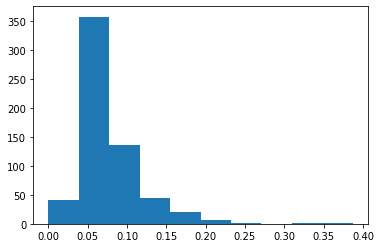

In [25]:
plt.hist( inflected_counts, bins=10)

(array([261., 268.,  53.,  18.,   9.,   0.,   0.,   0.,   1.,   2.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333]),
 <a list of 10 Patch objects>)

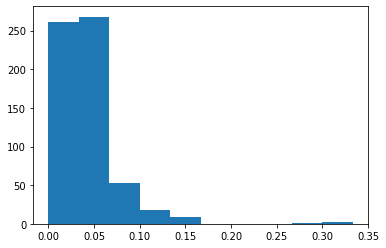

In [26]:
plt.hist(lemma_counts, bins=10)